In [1]:
import spacy
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner"])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
EPS = 1e-6

In [66]:
fun_fact_df = pd.read_csv('../data/til_title.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,5,8,9,13,14,15,16,19,21,22,24,27,28,33,34,35,41,46,58,60,62,63,64,65,68,74,79,85,92,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1720]:
required_columns = ['title', 'subreddit', 'permalink', 'score', 'created_utc']
fun_fact_df = fun_fact_df.dropna(axis='rows', subset=required_columns)

In [1721]:
banned_subreddits = ['circlejerk',
                     'ShittyTodayILearned',
                     'TheOnion',
                     'WTF',
                     # non-english
                     'Suomi',
                     'BitcoinDK',
                     'BitcoinNO',
                     'brasil',
                    ]
fun_fact_df = fun_fact_df[~fun_fact_df['subreddit'].isin(banned_subreddits)]

In [1722]:
fun_fact_df = fun_fact_df.reset_index(drop=True)

In [1723]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

In [1746]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=.8, ngram_range=(1,1), dtype=np.float32)
titles = fun_fact_df['title']
scores = fun_fact_df['score'].astype(np.int).to_numpy()
fun_fact_tfidf = vectorizer.fit_transform(titles)

In [1725]:
fun_fact_tfidf

<307909x125163 sparse matrix of type '<class 'numpy.float32'>'
	with 2785307 stored elements in Compressed Sparse Row format>

In [1726]:
len(vectorizer.get_feature_names())

125163

In [1727]:
len(fun_fact_df['title'])

307909

In [1728]:
np.sum(fun_fact_tfidf > 0, axis=1) # shows number of tfidf words per doc

matrix([[ 6],
        [10],
        [26],
        ...,
        [ 4],
        [14],
        [ 5]])

In [1729]:
features = vectorizer.get_feature_names()
f_vectors = np.array([nlp.vocab[f].vector for f in features])
weighted_embedding = fun_fact_tfidf.dot(f_vectors)
print(weighted_embedding.shape)

(307909, 300)


In [1730]:
n_weighted_embedding = weighted_embedding / (np.linalg.norm(weighted_embedding, axis=1)[:, np.newaxis] + EPS)

In [1731]:
print(np.linalg.norm(n_weighted_embedding[22291]))
print(np.linalg.norm(n_weighted_embedding[10493]))

0.9999999
0.9999999


In [1732]:
sparse_logs = fun_fact_tfidf.copy()
sparse_logs.data = np.log(sparse_logs.data)
entropy = -(fun_fact_tfidf.multiply(sparse_logs)).sum(axis=1)
entropy = np.minimum(1, np.log(np.asarray(entropy).flatten() + 1))

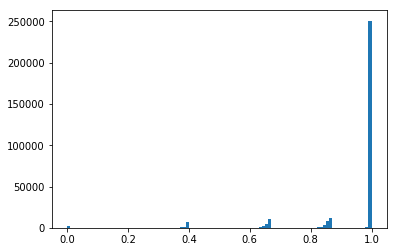

In [1733]:
plt.hist(entropy,bins=100)
plt.show()

In [1870]:
from datetime import datetime

def normalize_range(r):
    r = np.log(r)
    min_r = np.min(r)
    max_r = np.max(r)
    normalized_r = (r - min_r) / (max_r - min_r)
    return np.sqrt(normalized_r)

dates = fun_fact_df['created_utc'].astype(np.int).to_numpy()
old_dates_dist = scipy.stats.norm(np.min(dates), np.sqrt(np.var(dates) * 2))
p_old_dates = normalize_range(old_dates_dist.pdf(dates))
new_dates_dist = scipy.stats.norm(np.max(dates), np.sqrt(np.var(dates) * 2))
p_new_dates = normalize_range(new_dates_dist.pdf(dates))

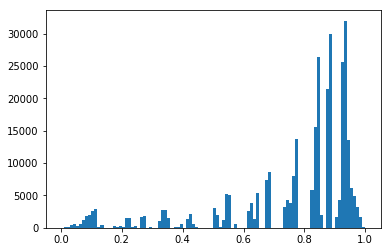

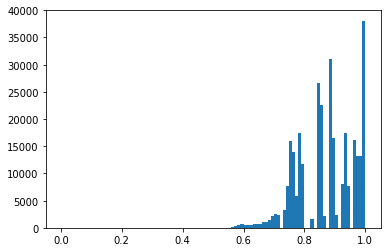

In [1871]:
plt.hist(p_old_dates, bins=100)
plt.show()
plt.hist(p_new_dates, bins=100)
plt.show()

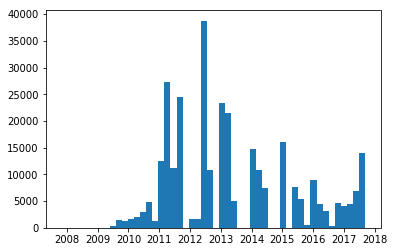

In [1872]:
import matplotlib.dates as mdates
mpl_data = mdates.epoch2num(dates)
fig, ax = plt.subplots()
ax.hist(mpl_data, bins=50)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.AutoDateLocator()))
plt.show()

# Begin query searching here

In [2044]:
query = "illegal immigration"
recency_sort = False
query_tfidf = vectorizer.transform([query])
query_weighted = query_tfidf.dot(f_vectors).flatten()
n_query_weighted = query_weighted / np.linalg.norm(query_weighted)
rankings = n_weighted_embedding.dot(n_query_weighted) + .1 * entropy
if recency_sort is not None:
    if recency_sort == True:
        rankings *= p_new_dates
    else:
        rankings *= p_old_dates
rankings_index = np.argsort(-rankings)
# fun_fact_df[["subreddit", "title"]].loc[rankings_index]

In [2045]:
query_tfidf.data

array([0.8214964, 0.5702136], dtype=float32)

In [2046]:
for i in range(20):
    print("{:.4f}".format(rankings[rankings_index[i]]),
          datetime.fromtimestamp(dates[rankings_index[i]]).year,
          "{:>5.0f}".format(scores[rankings_index[i]]),
          titles[rankings_index[i]])

0.8415 2011   532 TIL that illegal immigrants can become legal residents if they've been victims of serious crimes here in the US. The law was created so that illegal immigrants would come forward and help authorities solve major crimes.
0.8169 2011     1 TIL that immigration fraud really isn't investigated.
0.7938 2011     0 TIL that it is VERY easy for illegal immigrant to get permanent residency in San Francisco... Just accuse someone of a crime, get a police report, be "helpful", and they're on their way to a U-Visa 
0.7920 2011     1 TIL That Obama's uncle is an illegal citizen, currently awaiting deportation.
0.7911 2012     1 TIL being married to a US Citizen doesn't always protect an illegal immigrant from deportation, even if they were a victim of human trafficking.
0.7842 2011    53 TIL that there is a tax on marijuana in 20 US states, despite its being illegal in all of them
0.7827 2012    35 TIL one year ago today, Alabama passed a tough anti-immigration law that makes it a

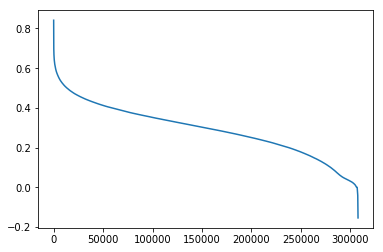

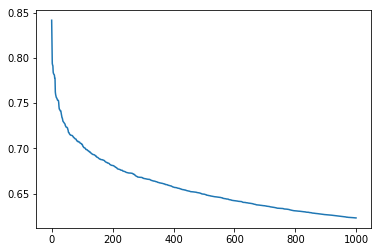

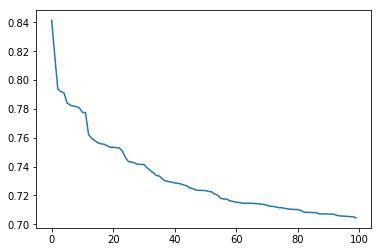

In [2047]:
plt.plot(rankings[rankings_index])
plt.show()
plt.plot(rankings[rankings_index[:1000]])
plt.show()
plt.plot(rankings[rankings_index[:100]])
plt.show()

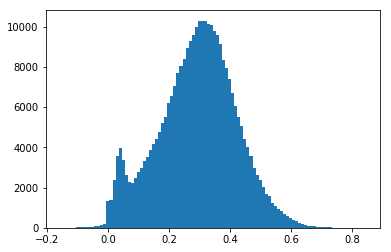

In [2048]:
plt.hist(rankings[rankings_index], bins=100)
plt.show()

In [2049]:
print(np.sum(scipy.stats.zscore(rankings) > 3.5))
print(np.sum(scipy.stats.zscore(rankings) < -3.5))
print(np.std(rankings))
print(scipy.stats.skew(rankings))

33
0
0.12763141
-0.1453484445810318


In [2050]:
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [2051]:
upper_zscore = np.sum(scipy.stats.zscore(rankings) > 3.5)
lower_zscore = np.sum(scipy.stats.zscore(rankings) < -3.5)
scale = np.std(rankings) * abs(1 / scipy.stats.skew(rankings))
TOP_HITS_KMEANS = max(15, min(200, int((upper_zscore + lower_zscore) * scale)))
print("{}-{}".format(0, TOP_HITS_KMEANS))
ranked_rankings = rankings[rankings_index[:TOP_HITS_KMEANS]]
ranked_titles = titles[rankings_index[:TOP_HITS_KMEANS]].tolist()
ranked_scores = scores[rankings_index[:TOP_HITS_KMEANS]]
top_ranked_em = n_weighted_embedding[rankings_index[:TOP_HITS_KMEANS]]
clustering = SpectralClustering(n_clusters=10, random_state=0).fit(top_ranked_em)

0-28


In [2052]:
for i in range(min(20, TOP_HITS_KMEANS)):
    print(clustering.labels_[i], "{:.4f}".format(ranked_rankings[i]), ranked_titles[i])

0 0.8415 TIL that illegal immigrants can become legal residents if they've been victims of serious crimes here in the US. The law was created so that illegal immigrants would come forward and help authorities solve major crimes.
8 0.8169 TIL that immigration fraud really isn't investigated.
5 0.7938 TIL that it is VERY easy for illegal immigrant to get permanent residency in San Francisco... Just accuse someone of a crime, get a police report, be "helpful", and they're on their way to a U-Visa 
0 0.7920 TIL That Obama's uncle is an illegal citizen, currently awaiting deportation.
0 0.7911 TIL being married to a US Citizen doesn't always protect an illegal immigrant from deportation, even if they were a victim of human trafficking.
1 0.7842 TIL that there is a tax on marijuana in 20 US states, despite its being illegal in all of them
5 0.7827 TIL one year ago today, Alabama passed a tough anti-immigration law that makes it a crime to give an illegal immigrant a ride in your car.
4 0.782

In [2053]:
# closest, _ = pairwise_distances_argmin_min(clustering.cluster_centers_, top_ranked_em[:TOP_HITS_KMEANS])
# for c, i in enumerate(closest):
#     print(c, ranked_titles[i])

In [2054]:
_, best_similarity = np.unique(clustering.labels_, return_index=True)
for c, i in enumerate(best_similarity):
    print(c, "{:<5.0f}".format(ranked_scores[i]), ranked_titles[i])

0 532   TIL that illegal immigrants can become legal residents if they've been victims of serious crimes here in the US. The law was created so that illegal immigrants would come forward and help authorities solve major crimes.
1 53    TIL that there is a tax on marijuana in 20 US states, despite its being illegal in all of them
2 3     TIL that the first internet spam was ironically from two Arizona lawyers taking advantage of would-be immigrants
3 1     TIL it's actually illegal in the United States to boycott Israel.
4 5     TIL where Prostitution is legal/illegal around the world, p.s. the US needs to catch up!
5 0     TIL that it is VERY easy for illegal immigrant to get permanent residency in San Francisco... Just accuse someone of a crime, get a police report, be "helpful", and they're on their way to a U-Visa 
6 7     TIL rape rates in Sweden have tripled since allowing liberal immigration of muslims.
7 1     "TIL Free OISC Immigration Training"
8 1     TIL that immigration fra

In [2055]:
min_allowed_similarity = np.min(ranked_rankings[best_similarity])
best_score = [np.argsort(-np.where((clustering.labels_ == c) & (ranked_rankings >= min_allowed_similarity), ranked_scores, np.nan), kind='stable')[0] for c in range(10)]
for c, i in enumerate(best_score):
    print(c, "{:<5.0f}".format(ranked_scores[i]), ranked_titles[i])

0 532   TIL that illegal immigrants can become legal residents if they've been victims of serious crimes here in the US. The law was created so that illegal immigrants would come forward and help authorities solve major crimes.
1 55    TIL: Why the states can't simply legalize and tax pot.
2 5     TIL that illegals pay taxes too - today more than ever
3 42    TIL it's actually illegal in the United States to boycott Israel.
4 35    TIL It's illegal to name your child 'Brfxxccxxmnpcccclllmmnprxvclmnckssqlbb11116' in Sweden. That and 9 other illegal names from over the World.
5 35    TIL one year ago today, Alabama passed a tough anti-immigration law that makes it a crime to give an illegal immigrant a ride in your car.
6 7     TIL rape rates in Sweden have tripled since allowing liberal immigration of muslims.
7 1     "TIL Free OISC Immigration Training"
8 129   TIL I learned that the drug czar is LEGALLY required to oppose all research regarding illegal drugs.
9 19    TIL that Canada u

[t-SNE] Computing 27 nearest neighbors...
[t-SNE] Indexed 28 samples in 0.000s...
[t-SNE] Computed neighbors for 28 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 28 / 28
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.655445
[t-SNE] KL divergence after 1000 iterations: 0.495513


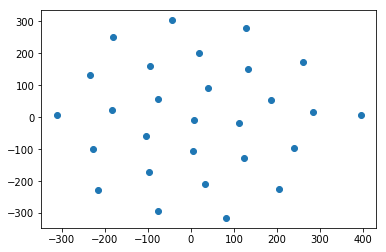

In [2056]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1)
projected = tsne.fit_transform(top_ranked_em)
plt.scatter(projected[:,0], projected[:,1])
plt.show()

## QED.

# Doing more clusters and picking biggest ones

In [2057]:
TOP_HITS_KMEANS = max(40,np.sum(scipy.stats.zscore(rankings[rankings_index]) > 3.5))
if TOP_HITS_KMEANS > 200:
    TOP_HITS_KMEANS = 200
print(TOP_HITS_KMEANS)
ranked_titles = titles[rankings_index].tolist()
top_ranked_em = n_weighted_embedding[rankings_index]
kmeans = KMeans(n_clusters=20, random_state=0).fit(top_ranked_em[:TOP_HITS_KMEANS])

40


In [2058]:
import collections
counter = collections.Counter(kmeans.labels_)
most_common = counter.most_common(10)
most_common = [i[0] for i in most_common]
closest2, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_[most_common], top_ranked_em[:TOP_HITS_KMEANS])
for c, i in enumerate(closest2):
    print(c, ranked_titles[i])

0 TIL one year ago today, Alabama passed a tough anti-immigration law that makes it a crime to give an illegal immigrant a ride in your car.
1 TIL prostitution is legal in a lot more countries than I thought it was 
2 TIL that there is a tax on marijuana in 20 US states, despite its being illegal in all of them
3 TIL that marijuana, "the most widely used illicit substance in the world," was not illegal in the US until 1937, the law was debated only 90 seconds, the American Medical Association was the only one who defended the idea that marijuana was not dangerous, and the government lied about the AMA.
4 TIL being married to a US Citizen doesn't always protect an illegal immigrant from deportation, even if they were a victim of human trafficking.
5 TIL that prostitution is illegal in USA. 
6 TIL that Canada used the Roe v. Wade case as grounds to find Canada's federal law restricting access to abortions unconstitutional in 1988.
7  TIL the birth of all Mexican Drug Cartels can be trace

# Instead of choosing point nearest to each centroid, choose the point with the highest similarity

In [2059]:
def firstElementOfEachCluster(seq, num):
    clusters_included = set(most_common)
    res = {}
    for i, el in enumerate(seq):
        if el not in clusters_included:
            continue
        if el<10 and el not in res:
            res[el] = i
        if len(res) > num:
            return res
    
    return res

In [2060]:
mostSimilarInEachCluster =  firstElementOfEachCluster(kmeans.labels_, 10)
ranked_rankings = rankings[rankings_index]
lst = []
for key in mostSimilarInEachCluster:
    lst.append((ranked_rankings[mostSimilarInEachCluster[key]], ranked_titles[mostSimilarInEachCluster[key]]))
lst = sorted(lst, key=lambda x: x[0], reverse = True)
for sim, fact in lst:
    print(sim, fact)

0.84152335 TIL that illegal immigrants can become legal residents if they've been victims of serious crimes here in the US. The law was created so that illegal immigrants would come forward and help authorities solve major crimes.
0.7920055 TIL That Obama's uncle is an illegal citizen, currently awaiting deportation.
0.78415793 TIL that there is a tax on marijuana in 20 US states, despite its being illegal in all of them
0.78195244 TIL where Prostitution is legal/illegal around the world, p.s. the US needs to catch up!
0.77743095 TIL It's illegal to name your child 'Brfxxccxxmnpcccclllmmnprxvclmnckssqlbb11116' in Sweden. That and 9 other illegal names from over the World.
0.7533849 TIL it's actually illegal in the United States to boycott Israel.
0.75296146 TIL I learned that the drug czar is LEGALLY required to oppose all research regarding illegal drugs.


In [2061]:
# cluster number to top 10 based on similaitity
def top10OfEachCluster(seq, num):
    res = {}
    clusters_included = set(most_common)
    for i, el in enumerate(seq):
        if el not in clusters_included:
            continue
        if el not in res:
            res[el] = [i]
        elif len(res[el]) < num:
            res[el].append(i) 
    return res

In [2062]:
kmeans.labels_

array([ 3, 19,  3,  1,  1,  5,  3,  9, 17,  3, 18,  6, 14, 11,  9, 13,  9,
        5,  2,  8,  8,  7,  0,  5, 15, 16,  4, 10,  0,  0,  0, 15,  5,  6,
       13, 11,  9, 12,  3,  9], dtype=int32)

## Take the 10 most similar and choose the top 4 based on score from each cluster

In [2063]:
results = top10OfEachCluster(kmeans.labels_, 10)
results

{3: [0, 2, 6, 9, 38],
 1: [3, 4],
 5: [5, 17, 23, 32],
 9: [7, 14, 16, 36, 39],
 6: [11, 33],
 11: [13, 35],
 13: [15, 34],
 8: [19, 20],
 0: [22, 28, 29, 30],
 15: [24, 31]}

In [657]:
for key in results:
    results[key].sort(key=lambda x: ranked_scores[x], reverse = True)
    results[key] = results[key][:4]

In [658]:
for key in results:
    for idx in results[key]:
        print (key, "{:.4f}".format(ranked_rankings[idx]), ranked_scores[idx], ranked_titles[idx] )

12 0.8233 256.0 TIL Cisgenders have their own language
12 0.7699 3.0 TIL the history of the English language.
12 0.7881 0.0 TIL about a language called "Lolcode."
19 0.8009 13.0 TIL Pidgin Language is the form of communication between people with no language in common
19 0.8176 1.0 TIL the BBC website has a translated version of the news in Pidgin, a grammatically simplified form of a language, used for communication between people not sharing a common language.
11 0.8033 124.0 TIL India has no official language, with English being the most important language for national, political, and commercial communication
11 0.7621 1.0 TIL Spanish is not one of the top 3 useful foreign languages for business
11 0.7594 0.0 TIL That the German language was the second most spoken language in the United States but the use of the language was strongly suppressed during World War I.
3 0.8032 838.0 TIL of Blissymbolics, an unspoken, written language that was invented as an easy to learn form of communi

In [659]:
results

{12: [0, 20, 8],
 19: [4, 1],
 11: [2, 23, 27],
 3: [3, 34, 28, 15],
 1: [5, 26, 13],
 0: [36, 6, 38, 21],
 8: [7],
 4: [11, 9],
 18: [14, 32, 25, 29],
 2: [30, 39]}

## ask user if they would like results by simialrity or score

In [660]:
def topResultsSorted(results, method = 'similarity'):
    if method == 'similarity':
        for key in results:
            results[key].sort(key=lambda x: ranked_rankings[x], reverse = True) #sorts within a cluster
            sorted_results = sorted(results.items(), key=lambda x: ranked_rankings[x[1][0]], reverse = True) #sorts all clusters
    elif method == 'score':
        for key in results:
            results[key].sort(key=lambda x: ranked_scores[x], reverse = True)
            sorted_results = sorted(results.items(), key=lambda x: ranked_scores[x[1][0]], reverse = True)
    return sorted_results

In [661]:
sorted_results = topResultsSorted(results, "score")
for cluster_id, l in sorted_results:
    print (cluster_id, "{:.4f}".format(ranked_rankings[l[0]]), 
           ranked_scores[l[0]],ranked_titles[l[0]])

3 0.8032 838.0 TIL of Blissymbolics, an unspoken, written language that was invented as an easy to learn form of communication for use between people of all languages
1 0.7928 322.0 TIL Sign language is not universal. There is about one sign language for each spoken language (and, for example, American English' Sign Language differs from British English' Sign Language).
12 0.8233 256.0 TIL Cisgenders have their own language
11 0.8033 124.0 TIL India has no official language, with English being the most important language for national, political, and commercial communication
0 0.7488 49.0 TIL Wikipedia has a Simple English language for in-depth articles.
19 0.8009 13.0 TIL Pidgin Language is the form of communication between people with no language in common
4 0.7858 9.0 TIL that abbreviations in different languages use words that are also in that language
18 0.7751 3.0 TIL there is a language option on wikipedia called "Simple English" for people whose first language is not english, lo

In [662]:
sorted_results = topResultsSorted(results)

for cluster_id, l in sorted_results:
    print (cluster_id, "{:.4f}".format(ranked_rankings[l[0]]), 
           ranked_scores[l[0]],ranked_titles[l[0]])

12 0.8233 256.0 TIL Cisgenders have their own language
19 0.8176 1.0 TIL the BBC website has a translated version of the news in Pidgin, a grammatically simplified form of a language, used for communication between people not sharing a common language.
11 0.8033 124.0 TIL India has no official language, with English being the most important language for national, political, and commercial communication
3 0.8032 838.0 TIL of Blissymbolics, an unspoken, written language that was invented as an easy to learn form of communication for use between people of all languages
1 0.7928 322.0 TIL Sign language is not universal. There is about one sign language for each spoken language (and, for example, American English' Sign Language differs from British English' Sign Language).
0 0.7914 2.0 TIL Google can understand Birdperson's language
8 0.7886 1.0 TIL that Clicking through other languages on a Wikipedia article yields *tons* more information, especially if you are multilingual, as some articl

In [668]:
index = list(ranked_df.itertuples())
results = [
            {
                "type": "submission",
                "title": ranked_df.iloc[d]["title"],
                "subreddit": ranked_df.iloc[d]['subreddit'],
                "permalink": ranked_df.iloc[d]['permalink'],
                "score": ranked_df.iloc[d]['score']
            }
            for d in [i[1][0] for i in sorted_results]
        ]
#show_more = []

KeyError: '[permalink]'

In [667]:
# index

In [664]:
[i[1][0] for i in sorted_results]

[0, 1, 2, 3, 5, 6, 7, 9, 14, 30]

In [665]:
sorted_results

[(12, [0, 8, 20]),
 (19, [1, 4]),
 (11, [2, 23, 27]),
 (3, [3, 15, 28, 34]),
 (1, [5, 13, 26]),
 (0, [6, 21, 36, 38]),
 (8, [7]),
 (4, [9, 11]),
 (18, [14, 25, 29, 32]),
 (2, [30, 39])]

In [666]:
results

[{'type': 'submission',
  'title': 'TIL Cisgenders have their own language',
  'subreddit': 'TumblrInAction',
  'permalink': '/r/TumblrInAction/comments/35btdo/til_cisgenders_have_their_own_language/',
  'score': 256.0},
 {'type': 'submission',
  'title': 'TIL the BBC website has a translated version of the news in Pidgin, a grammatically simplified form of a language, used for communication between people not sharing a common language.',
  'subreddit': 'todayilearned',
  'permalink': '/r/todayilearned/comments/6x1ju1/til_the_bbc_website_has_a_translated_version_of/',
  'score': 1.0},
 {'type': 'submission',
  'title': 'TIL India has no official language, with English being the most important language for national, political, and commercial communication',
  'subreddit': 'todayilearned',
  'permalink': '/r/todayilearned/comments/180bhk/til_india_has_no_official_language_with_english/',
  'score': 124.0},
 {'type': 'submission',
  'title': 'TIL of Blissymbolics, an unspoken, written lan